<a href="https://colab.research.google.com/github/Abhinandan-Pal/MarkRNN/blob/master/MarksRNN_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing and dowloading**

In [33]:
import tensorflow_datasets as tfds
import tensorflow as tf
from IPython import display
import re
from sklearn.model_selection import train_test_split
import os
import io
import time
import matplotlib.pyplot as plt

In [7]:
# https://github.com/mahnazkoupaee/WikiHow-Dataset
# Refer to this link to get the dataset used

In [2]:
from google.colab import drive
drive.mount("drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [3]:
filePath = "drive/My Drive/MarksRNN/"

In [4]:
import pandas as pd
import random
data = pd.read_csv(filePath + "wikihowAll.csv")

# **Preprocessing**

In [5]:
def newSent(Para,Score):
    Para =  Para.replace("\n\n", "\n").replace("\n\n\n", "\n")
    sentences = Para.split('\n')
    newSents = ""
    for sent in sentences:
        if (random.random() < Score):
            newSents = newSents + "\n" + sent
    return newSents

In [6]:
newData = pd.DataFrame(columns = ['Answer', 'Marking','Score'])
data["text"]= data["text"].astype(str)
data["headline"]= data["headline"].astype(str)
j = 0 
#len(data)
for i in range(999):
    display.clear_output(wait=True)
    print(str(i)+"/"+str(len(data)))
    for score10 in range(5,11):
        newData.loc[j] = [newSent(data['text'][i],score10/10) , data['headline'][i] , score10]
        j = j + 1

998/215365


In [8]:
def preprocess(ans,mark):    
    mark = mark.replace(".,",".")
    ans = re.sub(r'[.]+[\n]+[,]',".\n", ans)
    return ans,mark

In [9]:
answer = []
marking = []
score = []

for i in range(len(newData)):
  if len(newData['Marking'][i] ) < (0.75*len(newData['Answer'][i])):
    if( ( len(newData['Marking'][i])<2000 ) and ( len(newData['Answer'][i] )<4000) ):
      a,b = preprocess(newData['Answer'][i],newData['Marking'][i])
      
      answer.append(a)
      marking.append(b)

      score.append([newData['Score'][i]])

In [10]:
len(answer)

4422

In [11]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [12]:
ans_tensor , ans_token = tokenize(answer)
mark_tensor , mark_token = tokenize(marking)
score_tensor_train = tf.convert_to_tensor(score ,dtype=tf.float32)

In [13]:
print(ans_tensor.shape)
print(mark_tensor.shape)
print(score_tensor_train)

(4422, 771)
(4422, 246)
tf.Tensor(
[[ 5.]
 [ 6.]
 [ 7.]
 ...
 [ 8.]
 [ 9.]
 [10.]], shape=(4422, 1), dtype=float32)


In [14]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(mark_token, mark_tensor[0])
print ()


Input Language; index to word mapping
215 ----> 
keep
1766 ----> related
575 ----> supplies
9 ----> in
3 ----> the
197 ----> same
1982 ----> area.
make
32 ----> an
255 ----> effort
2 ----> to
220 ----> clean
4 ----> a
1983 ----> dedicated
1984 ----> workspace
153 ----> after
160 ----> every
1985 ----> session.
place
1118 ----> loose
575 ----> supplies
9 ----> in
1986 ----> large,
704 ----> clearly
1987 ----> visible
1988 ----> containers.
use
1989 ----> clotheslines
6 ----> and
1990 ----> clips
2 ----> to
136 ----> hang
785 ----> sketches,
1119 ----> photos,
6 ----> and
1120 ----> reference
1991 ----> material.
use
160 ----> every
1121 ----> inch
8 ----> of
3 ----> the
862 ----> room
10 ----> for
1992 ----> storage,
385 ----> especially
1993 ----> vertical
1994 ----> space.
use
1995 ----> chalkboard
1996 ----> paint
2 ----> to
46 ----> make
290 ----> space
10 ----> for
1997 ----> drafting
1122 ----> ideas
71 ----> right
16 ----> on
3 ----> the
1998 ----> walls.
purchase
4 ----> a
1999 

In [16]:
BUFFER_SIZE = len(ans_tensor)
BATCH_SIZE = 64
steps_per_epoch = len(ans_tensor)//BATCH_SIZE

#embedding_dim = 256
#units = 1024

vocab_ans_size = len(ans_token.word_index)+1
vocab_mark_size = len(mark_token.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((ans_tensor,mark_tensor,score_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [17]:
print(vocab_ans_size)
print(vocab_mark_size)

32731
8914


In [18]:
example_ans_batch, example_mark_batch , example_score = next(iter(dataset))
example_ans_batch.shape, example_mark_batch.shape,example_score.shape

(TensorShape([64, 771]), TensorShape([64, 246]), TensorShape([64, 1]))

# **Setting up model**

In [19]:
class MRNN(tf.keras.Model):
  def __init__(self):
    super(MRNN, self).__init__()
    self.answer_hidden_net = tf.keras.Sequential(
      [
          #hub.KerasLayer(module_url),
          tf.keras.layers.Embedding(vocab_ans_size, 64),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(512, activation='relu')
      ]
    )

    self.marking_hidden_net = tf.keras.Sequential(
        [
          #hub.KerasLayer(module_url),
          tf.keras.layers.Embedding(vocab_mark_size, 64),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(256, activation='relu')
        ]
    )
    self.score_output_net = tf.keras.Sequential(
        [
          tf.keras.layers.Dense(256, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(128, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(1)
        ]
    )
  @tf.function
  def encode_ans(self, x):
    hidden_ans = self.answer_hidden_net(x)
    #print(mean.shape)
    return hidden_ans

  def encode_mark(self, x):
    hidden_mark = self.marking_hidden_net(x)
    #print(mean.shape)
    return hidden_mark
  
  def implement(self,ans,mark):
    hidden_ans = self.answer_hidden_net(ans)
    hidden_mark = self.marking_hidden_net(mark)
    hidden_combined = tf.concat([hidden_ans, hidden_mark], 1)
    predicted_score = self.score_output_net(hidden_combined)
    return predicted_score


In [20]:
model = MRNN()

In [21]:
model.answer_hidden_net(example_ans_batch).shape

TensorShape([64, 512])

In [22]:
model.marking_hidden_net(example_mark_batch).shape

TensorShape([64, 256])

In [23]:
predicted_score_example = model.implement(example_ans_batch,example_mark_batch).shape

# **IMPLEMENTATION**

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

def loss_function(real, pred):
  loss_ = loss_object(real, pred)
  return loss_ 

In [25]:
loss_eg = loss_function(example_score,predicted_score_example)
loss_eg

<tf.Tensor: shape=(), dtype=int32, numpy=1614>

In [26]:
@tf.function
def train_step(ans, mark,score):
  loss = 0

  with tf.GradientTape() as tape:

    predicted_score = model.implement(ans,mark)
    loss = loss_function(score,predicted_score)


  variables = model.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return loss

In [27]:
steps_per_epoch

69

In [29]:
EPOCHS = 2
loss_history_train = []
loss_history_val = []
for epoch in range(EPOCHS):
  start = time.time()

  total_loss = 0
  set_loss = 0
  for (batch, (ans, mark,score)) in enumerate(dataset.take(steps_per_epoch)):
    if (batch % 10 == 0):
      predicted_score = model.implement(ans,mark)
      loss_val = loss_function(score,predicted_score)

      model.answer_hidden_net.save_weights("answer_hidden_net_m.hdf5")
      model.marking_hidden_net.save_weights("marking_hidden_net.hdf5")
      model.score_output_net.save_weights("score_output_net.hdf5")

      
      if(batch != 0):
        loss_history_train.append(set_loss/9)
        print('SAVING MODEL TRAIN RESULT: Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   set_loss/9))
      set_loss = 0
      print('VALIDATION RESULT: Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   loss_val.numpy()))
      loss_history_val.append(loss_val.numpy())
    else:
      batch_loss = train_step(ans, mark,score)
      total_loss += batch_loss
      set_loss += batch_loss.numpy()
      if batch % 1 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))

  # saving (checkpoint) the model every 2 epochs

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

VALIDATION RESULT: Epoch 1 Batch 0 Loss 56.0613
Epoch 1 Batch 1 Loss 61.3920
Epoch 1 Batch 2 Loss 51.2119
Epoch 1 Batch 3 Loss 47.4445
Epoch 1 Batch 4 Loss 39.0388
Epoch 1 Batch 5 Loss 9.1807
Epoch 1 Batch 6 Loss 8.9053
Epoch 1 Batch 7 Loss 5.1812
Epoch 1 Batch 8 Loss 2.8317
Epoch 1 Batch 9 Loss 3.2319
SAVING MODEL TRAIN RESULT: Epoch 1 Batch 10 Loss 25.3798
VALIDATION RESULT: Epoch 1 Batch 10 Loss 4.5899
Epoch 1 Batch 11 Loss 5.0823
Epoch 1 Batch 12 Loss 4.8432
Epoch 1 Batch 13 Loss 3.1447
Epoch 1 Batch 14 Loss 2.4876
Epoch 1 Batch 15 Loss 3.3794
Epoch 1 Batch 16 Loss 3.8059
Epoch 1 Batch 17 Loss 3.0326
Epoch 1 Batch 18 Loss 3.4277
Epoch 1 Batch 19 Loss 2.9082
SAVING MODEL TRAIN RESULT: Epoch 1 Batch 20 Loss 3.5680
VALIDATION RESULT: Epoch 1 Batch 20 Loss 3.3968
Epoch 1 Batch 21 Loss 2.6951
Epoch 1 Batch 22 Loss 3.3838
Epoch 1 Batch 23 Loss 2.6630
Epoch 1 Batch 24 Loss 2.6595
Epoch 1 Batch 25 Loss 2.9932
Epoch 1 Batch 26 Loss 2.9478
Epoch 1 Batch 27 Loss 3.1341
Epoch 1 Batch 28 Loss 3

<function matplotlib.pyplot.show>

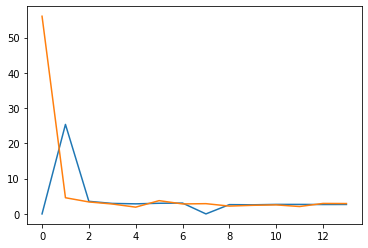

In [34]:
plt.plot(loss_history_train,label="Train")# Blue
plt.plot(loss_history_val,label="Validation")# Yellow 
plt.show

In [35]:
model.answer_hidden_net.load_weights("answer_hidden_net_m.hdf5")
model.marking_hidden_net.load_weights("marking_hidden_net.hdf5")
model.score_output_net.load_weights("score_output_net.hdf5")